In [1]:
import matplotlib.pyplot as plt

Pair = tuple[int, int]

class Rect:
    def __init__(self, min: Pair, max: Pair):
        self.min = min
        self.max = max

def draw_rect(ax: plt.Axes, rect: Rect, spec = ""):
    # Use SYCL conventions, flip coordinates
    ax.plot([rect.min[1], rect.min[1]], [rect.min[0], rect.max[0]], spec)
    ax.plot([rect.max[1], rect.max[1]], [rect.min[0], rect.max[0]], spec)
    ax.plot([rect.min[1], rect.max[1]], [rect.min[0], rect.min[0]], spec)
    ax.plot([rect.min[1], rect.max[1]], [rect.max[0], rect.max[0]], spec)

class Split:
    def __init__(self, domain: Pair, constraints: Pair, chunks: list[Rect]):
        # Sanity check chunks (we assume them to be in linearized order along fast dimension)
        check_domain: Pair = [0, chunks[0].max[0]]
        for chunk in chunks:
            if ((chunk.max[0] - chunk.min[0]) % constraints[0] != 0):
                print(f"Sanity check failed: Dim 0 chunk size ({chunk.max[0] - chunk.min[0]}) not evenly divisible by constraint ({constraints[0]})")
                break
            if ((chunk.max[1] - chunk.min[1]) % constraints[1] != 0):
                print(f"Sanity check failed: Dim 1 chunk size ({chunk.max[1] - chunk.min[1]}) not evenly divisible by constraint ({constraints[1]})")
                break

            if chunk.min[1] == check_domain[1]:
                assert(chunk.max[0] == check_domain[0])
            else:
                assert(chunk.min[0] == check_domain[0])
            check_domain = chunk.max
        if (check_domain[0] == domain[0] and check_domain[1] != domain[1]):
            print(f"Sanity check failed: Chunks do not cover domain exactly")

        self.domain = domain
        self.constraints = constraints
        self.chunks = chunks

In [10]:
import numpy as np

def assign_factors(factor: int, domain: Pair, constraints: Pair, num_chunks: int):
    max_chunks = [domain[0] // constraints[0], domain[1] // constraints[1]]
    f0 = factor
    f1 = num_chunks // factor

    # Decide in which direction to split by first checking which
    # factor assignment produces more chunks under the given constraints.
    split0 = [min(f0, max_chunks[0]), min(f1, max_chunks[1])]
    split1 = [min(f1, max_chunks[0]), min(f0, max_chunks[1])]
    count0 = split0[0] * split0[1]
    count1 = split1[0] * split1[1]

    if count0 == count1:
        # If we're tied for the number of chunks we can create,
        # try some heuristics to decide.

        # TODO: Yet another heuristic we should consider is how even chunk sizes are
        # I.e., how balanced the workload is.

        # If domain is square(-ish), prefer splitting along slower dimension
        # (These bounds have been chosen arbitrarily!)
        if 0.95 < np.sqrt(domain[0] * domain[1]) / domain[0] < 1.05:
            return split0 if f0 >= f1 else split1

        # For non-square domain, prefer split that produces shorter edges (compare sum of circumferences)
        circ0 = domain[0] / split0[0] + domain[1] / split0[1]
        circ1 = domain[0] / split1[0] + domain[1] / split1[1]
        return split0 if circ0 < circ1 else split1

    elif count0 >= count1:
        return split0
    else:
        return split1

def split_2d(domain: Pair, constraints: Pair, num_chunks: int, warnings: list[str]):
    assert(domain[0] % constraints[0] == 0 and domain[1] % constraints[1] == 0)

    # Try to find factors as close to square root as possible, that also produce (or come closest to)
    # the requested number of chunks under the given constraints.
    f = int(np.floor(np.sqrt(num_chunks)))
    best_counts = [0, 0]
    while f >= 1:
        while f > 1 and num_chunks % f != 0:
            f -= 1
        counts = assign_factors(f, domain, constraints, num_chunks)
        if counts[0] * counts[1] > best_counts[0] * best_counts[1]:
            best_counts = counts
        if counts[0] * counts[1] == num_chunks:
            break
        f -= 1
    del f

    actual_num_chunks = best_counts

    if actual_num_chunks[0] * actual_num_chunks[1] != num_chunks:
        warnings.append(f"Created {actual_num_chunks[0]}x{actual_num_chunks[1]} chunks.")

    # Note that we don't necessarily construct a "small" or "large" chunk, but rather decide for each dimension separately.
    ideal_chunk_size = [domain[0] // actual_num_chunks[0], domain[1] // actual_num_chunks[1]]
    small_chunk_size = [(ideal_chunk_size[0] // constraints[0]) * constraints[0],
                        (ideal_chunk_size[1] // constraints[1]) * constraints[1]]
    large_chunk_size = [small_chunk_size[0] + constraints[0], small_chunk_size[1] + constraints[1]]
    num_large_chunks = [(domain[0] - small_chunk_size[0] * actual_num_chunks[0]) // constraints[0],
                        (domain[1] - small_chunk_size[1] * actual_num_chunks[1]) // constraints[1]]

    if num_large_chunks[0] + num_large_chunks[1]:
        warnings.append("Uneven split.")

    chunks: list[Rect] = []
    offset: Pair = [0, 0]
    for j in range(0, actual_num_chunks[0]):
        chunk_size: Pair = [large_chunk_size[0] if j < num_large_chunks[0] else small_chunk_size[0], 0]
        for i in range(0, actual_num_chunks[1]):
            chunk_size[1] = large_chunk_size[1] if i < num_large_chunks[1] else small_chunk_size[1]
            chunks.append(Rect([offset[0], offset[1]], [offset[0] + chunk_size[0], offset[1] + chunk_size[1]]))
            offset[1] += chunk_size[1]
        offset[0] += chunk_size[0]
        offset[1] = 0

    return Split(domain, constraints, chunks)

In [11]:
# TODO: Compute average/min/max circumference-to-area ratio?
def draw_split(domain: Pair, constraints: Pair, num_chunks: int, axfig = None):
    warnings = []
    split = split_2d(domain, constraints, num_chunks, warnings)

    if axfig is not None:
        fig, ax = axfig
    else:
        fig, ax = plt.subplots(figsize=(5, 5))

    max_dim = max(split.domain[0], split.domain[1])
    border = max_dim * 0.05
    ax.set_xlim(-border, max_dim + border)
    ax.set_ylim(-border, max_dim + border)
    ax.set_title(f"{domain[0]}x{domain[1]} ~ {constraints[0]}x{constraints[1]} | {num_chunks}")
    ax.text(max_dim / 2, -2 * border, ' '.join(warnings), wrap=True, ha='center', fontsize=10, color="red")
    # ax.axis("off")

    draw_rect(ax, Rect([0, 0], split.domain), "m:")
    for chunk in split.chunks:
        # Draw constraints
        if split.constraints[0] > 1 or split.constraints[1] > 1:
            for j in range(0, (chunk.max[0] - chunk.min[0]) // split.constraints[0]):
                for i in range(0, (chunk.max[1] - chunk.min[1]) // split.constraints[1]):
                    rect_min = (chunk.min[0] + j * split.constraints[0], chunk.min[1] + i * split.constraints[1])
                    rect_max = (rect_min[0] + split.constraints[0], rect_min[1] + split.constraints[1])
                    draw_rect(ax, Rect(rect_min, rect_max), "r:")
        draw_rect(ax, chunk, "k-")

    if axfig is not None:
        fig.show()

def draw_splits(specs: list):
    nrows=int(np.ceil(len(specs)/3))
    fig, axlist = plt.subplots(ncols=3, nrows=nrows, figsize=(9, nrows * 3))

    # Hide all axes
    for ax in axlist.flatten():
        ax.axis("off")

    for (i, (domain, constraints, num_chunks)) in enumerate(specs):
        draw_split(domain, constraints, num_chunks, (fig, axlist.flatten()[i]))

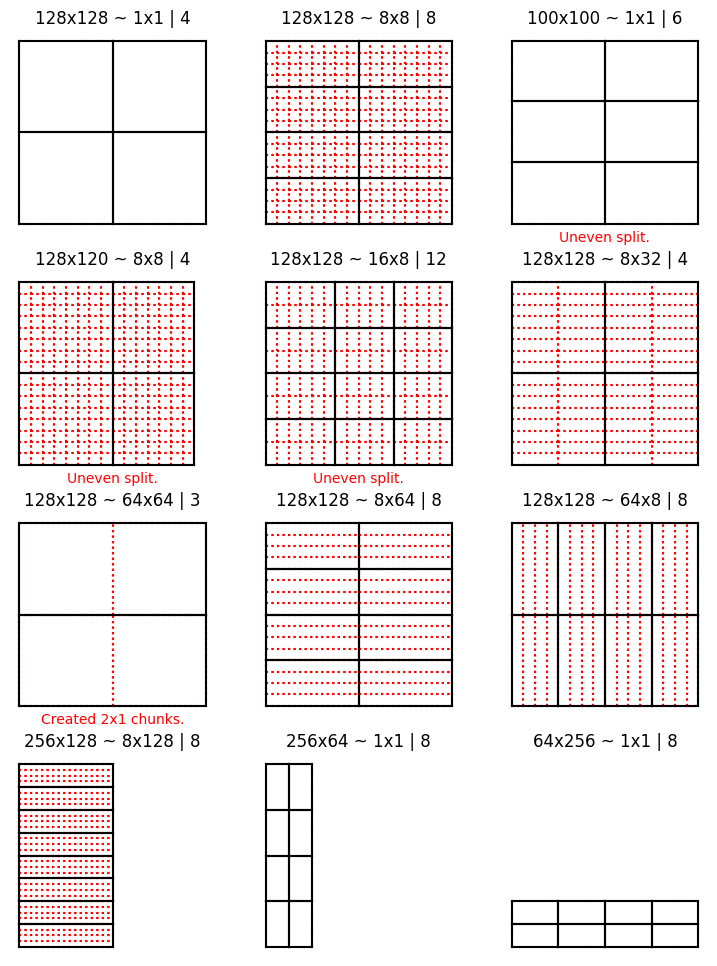

In [16]:
draw_splits([
    # Basic examples
    ([128, 128], [1, 1], 4),
    ([128, 128], [8, 8], 8),
    # Uneven splits
    ([100, 100], [1, 1], 6), # No constraints
    ([128, 120], [8, 8], 4),
    ([128, 128], [16, 8], 12),
    ([128, 128], [8, 32], 4),
    # Can't create requested number of chunks
    ([128, 128], [64, 64], 3),
    # Transpose split to fit constraints
    ([128, 128], [8, 64], 8),
    ([128, 128], [64, 8], 8),
    # Non-square domain
    ([256, 128], [8, 128], 8),
    # Transpose split to minimize edge lengths
    ([256, 64], [1, 1], 8),
    ([64, 256], [1, 1], 8),
])
